In [1]:
# General stuff
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.patches import Circle, Ellipse, Rectangle
import seaborn as sns

# Astropy stuff
from astropy.io import fits, ascii
from astropy.visualization import simple_norm  # this will come in handy to visualize images
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import table
import astropy.units as u

# For calculating flux
import sep

# Fitting stuff
from scipy import stats
from scipy.optimize import curve_fit
import General_functions as my

# For convolving
import warnings
from astropy.modeling.models import Sersic2D
from scipy.signal import fftconvolve as fft

# For creating loading bars
from tqdm.notebook import tqdm

# Import datasets, classifiers and performance metrics
from sklearn import datasets, manifold, metrics, preprocessing, utils
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy.spatial.distance import cdist

# Load tables and images

In [2]:
# Opening the IRAC ch1 image
def open_img(filename, hdu=0):
    
    if filename[-5:] == '.fits':  
        # if last 5 characters of the string are '.fits', the file is interpreted as FITS file
        hdul = fits.open(filename)  # open the HDU list of a FITS file 
                                    # (it may contain multiple data sets called Header Data Units)
            
        img = hdul[hdu].data  # save data from the unit n. 1 (or whatever is the `hdu` nuber) into `img` array
        hdr = hdul[hdu].header  # we may need also the header, which contain info about the image/data set
        # .header
        hdul.close()  # close the FITS file
        
    else:
        # if not FITS file, the function complains because it doesn't know other ways to do
        sys.exit("ERROR: open_img can deal with FITS file only.")
        
    return img, hdr  # the output is a tuple of two different objects

In [3]:
# Load IRAC ch1 image and residual image from ch1 + ch2
img, hdr = open_img('Resources/IRAC_ch1.fits', hdu=0)

In [5]:
# Load COSMOS catalogue
cosmos_tab = table.Table.read("Resources/COSMOS2020_CLASSIC_v1.5_formatted.fits",format="fits")

In [6]:
# Load residual catalogue
resi_tab = table.Table.read('Resources/irac-resid_v2_comb.fits', format='fits')

In [7]:
# Load catalogue with labels
labels_tab = table.Table.read('Resources/irac-resid_v2_visual-class.fits', format='fits')

# Plot a few objects, IRAC image and different vignettes
First we need to match coordinates of the cosmos_tab (to find objects in IRAC) with coordinates of resi_tab

In [8]:
#Sky matching function (adjusted so my_skycoord should be a SkyCoord class)
def match_cat(my_coord, cat_coord, r=1):

    # SkyCoord eats numbers with units.
    # This function assumes input coordinates are in decimal degree
    import astropy.units as u
    my_skycoord = SkyCoord(ra = my_coord[0], dec = my_coord[1], unit='deg')
    cat_skycoord = SkyCoord(ra = cat_coord[0], dec = cat_coord[1], unit='deg')
    
    idx, d2d, _ = match_coordinates_sky(my_skycoord, cat_skycoord)
    max_sep = r*u.arcsec
    sep_limit = d2d < max_sep
    #sep_limit not only the mask for selecting objects within the 2nd sample, but by itself can be used to select in the 1st sample.
    return sep_limit, idx[sep_limit]

We make sure that the coordinates from the catalogue are actually within the tile we are working with

In [9]:
# Load information from the tile's header
w = WCS(hdr)

# corner values on shape [y,x] for img
y_lim, x_lim = np.shape(img)

# Find pixel values in the image's corner (notice this is on the form x,y as in DS9 and not like imshow shows)
bottom_left = (11,11)
bottom_right = (x_lim-11, 11)
upper_left = (11, y_lim-11)
upper_right = (x_lim-11, y_lim-11) # We remove 11 pixels from border so we can always make 21x21 size cutouts

# Find RA DEC coordinates for these
corners = [bottom_left, bottom_right, upper_left, upper_right]
sky_corners = []

for i in range(4):
    skycoord = w.pixel_to_world(*corners[i])
    print(skycoord)
    sky_corners.append(skycoord) 

<SkyCoord (ICRS): (ra, dec) in deg
    (151.0623357, 1.29133181)>
<SkyCoord (ICRS): (ra, dec) in deg
    (149.05920166, 1.29128805)>
<SkyCoord (ICRS): (ra, dec) in deg
    (151.0636075, 3.29393279)>
<SkyCoord (ICRS): (ra, dec) in deg
    (149.05778055, 3.29382107)>


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [10]:
# The interval of right ascension is thus:
ra_int = (149.05920166, 151.0623357)

# Declination interval
dec_int = (1.29133181, 3.29393279) #change later

# Lets mask the cosmos catalogue to create a new catalogue containing only sources within the image
mask = (cosmos_tab['ALPHA_J2000'] > ra_int[0]) & (cosmos_tab['ALPHA_J2000'] < ra_int[1]) \
        & (cosmos_tab['DELTA_J2000'] > dec_int[0]) & (cosmos_tab['DELTA_J2000'] < dec_int[1])
match_cosmos = cosmos_tab[mask]

# Check how many objects are found
print(len(match_cosmos))

1718822


In [11]:
# We have removed the following
print('No. of removed objects:', len(cosmos_tab) - len(match_cosmos))
print('No. of objects left:', len(match_cosmos))

No. of removed objects: 1878
No. of objects left: 1718822


In [12]:
# Extract coordinates RA, DEC
cosmos_coord = [ match_cosmos['ALPHA_J2000'], match_cosmos['DELTA_J2000'] ] #no coordinates specific for IRAC in tab
resi_coord = [ resi_tab['ALPHA_J2000'], resi_tab['DELTA_J2000'] ] #same

# Get indices of matching objects
resi_idx, cosmos_idx = match_cat(resi_coord, cosmos_coord)

# Print number of matched objects
print('No. of matched objects:', np.sum(resi_idx))

No. of matched objects: 653


In [13]:
print('Fraction of residual objects matched', np.sum(resi_idx)/len(resi_tab))
print('Total number of objects in residual tab', len(resi_tab))

Fraction of residual objects matched 0.20802803440586173
Total number of objects in residual tab 3139


# Preparing the input for t-SNE (H,K,ch1,ch2)

We create a function that can take one channels vignettes and return an array with the shape (n objects, n parameters) where parameters are pixels in the vignette. This will prove useful later.

In [14]:
def ML_input(vignette_arr):
    
    # Flatten the entire array, will give one array with shape (1,N)
    flat_arr = vignette_arr.flatten()
    
    # Get the shape we expect for our input
    n_obj = len(vignette_arr)
    n_par = len(vignette_arr[0].flatten())
    
    # Reshape the array so each element is a flattened vignette
    X = flat_arr.reshape(n_obj, n_par)
    
    return X

In [15]:
# Get input from H
XH_temp = ML_input(resi_tab['VIGNET_H'][:,15:36,15:36])

# Get input from Ks
XKs_temp = ML_input(resi_tab['VIGNET_Ks'][:,15:36,15:36])

# Get input from ch1
X1_temp = ML_input(resi_tab['VIGNET_ch1'][:,15:36,15:36])

# Get the input from ch2
X2_temp = ML_input(resi_tab['VIGNET_ch2'][:,15:36,15:36])

# Concatenate the columns of the two inputs so we have one input with shape (n objects, 51*51+51*51)
X_unscaled = np.concatenate((XH_temp,XKs_temp,X1_temp,X2_temp), axis=1)
X_unscaled.shape

(3139, 1764)

In [16]:
# Lets normalise the data (Using minmax scaler corresponding to Iarys example)
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X_unscaled) # This should take care of Nans by itself

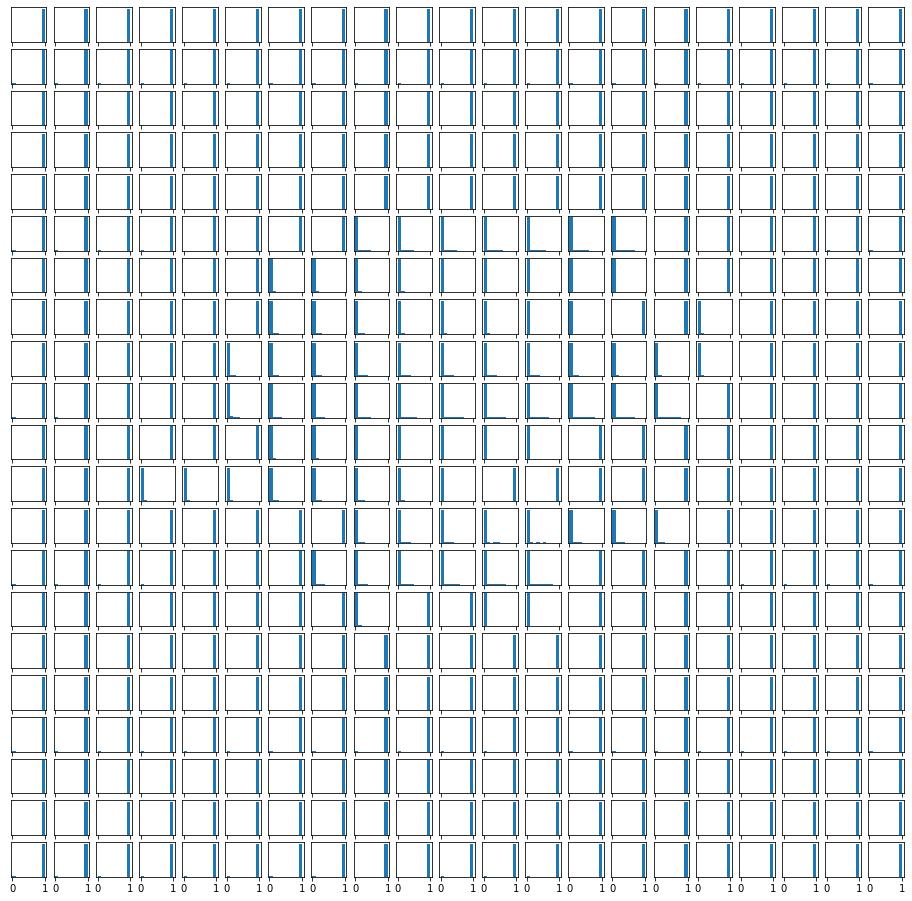

In [17]:
# We take a quick look to the distribution of values for each feature (only ch1 here)
fig, ax = plt.subplots(nrows=21, ncols=21, figsize=(16,16), sharex=True)
ax = ax.flatten()

# Scale channel 1 input
X1 = scaler.fit_transform(X1_temp)

for i in range(441):
    
    ax[i].hist(X1[:,i])
    ax[i].yaxis.set_visible(False)
    
plt.show()
plt.close()

# Choosing the right perplexity

There are multiple hyperparameters in t-SNE we should tune, the most important being the perplexity. We will therefor start of by performing the embedding for different perplexities and seeing which one is best. Notice that the perplexity would have to be tuned for another sample since it is very dependent on for example how many objects in a sample there are. Generally we can say that the perplexity is a value determining how many neighbours should be considered in the embedding, and changing the perplexity is thus a trade of between global and loc structures. The author of t-SNE suggest values between 5 and 50.

Another thing to look at is the n_iter, the maximum number of iterations for the optimization, which should be at least higher than 250. We chose n_iter so we find a stable solution, meaning that if we change the n_iter a little nothing crazy will happen.

In [18]:
# Define perplexities to try out
perplexities = [2, 5, 10, 20, 30, 40, 50, 80, 100]
n_iter = 10000
learning_rate=100
n_iter_without_progress=300

# Perform embedding for all
X_tsne_arr = []
n_iter_arr = []

for i in tqdm(range(len(perplexities))):
    
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexities[i], 
                         n_iter=n_iter, n_iter_without_progress=300,learning_rate=learning_rate)
    X_tsne = tsne.fit_transform(X)
    
    X_tsne_arr.append(X_tsne)
    n_iter_arr.append(tsne.n_iter_)

  0%|          | 0/9 [00:00<?, ?it/s]

In [19]:
n_iter_arr

[9999, 9999, 9999, 9999, 9999, 6349, 9999, 4599, 6499]

In [20]:
# Save the embedding so we dont have to run it again
import pickle
with open('Saved_Results/embedding.pickle', 'wb') as f:
    pickle.dump(X_tsne_arr, f)

## Labeling color with blue and red udefined color marked separetly

Let now try to plot the results from the different perplexities, but with no color coding it is hard to see whether the features in the embedding are physically meaningful. Therefor we start by calculating the colors of the objects so we can plot the results with a colormap representing the colors.

When calculating the colors we encounter a problem, some negative fluxes result in undefined magnitudes. To find out whether the problem is in the bluer or redder band that goes into the calculation of the color, we will calculate the magnitude of each band seperately to find out in which band the problem lies.

In [21]:
# Define colors myself
uvista = 30
irac = 21.58

# Calculate magnitudes in each band
mag_H =  -2.5*np.log10(resi_tab['FLUX_APER_H'][:,0]) + uvista
mag_Ks = -2.5*np.log10(resi_tab['FLUX_APER_Ks'][:,0]) + uvista
mag_ch1 = -2.5*np.log10(resi_tab['FLUX_APER_ch1'][:,0]) + irac
mag_ch2 = -2.5*np.log10(resi_tab['FLUX_APER_ch2'][:,0]) + irac

# Extract NAN values from each array (as masks)
mask_H = np.isnan(mag_H)
mask_Ks = np.isnan(mag_Ks)
mask_ch1 = np.isnan(mag_ch1)
mask_ch2 = np.isnan(mag_ch2)

# Calculate colors (including Nan, we will plot over these anyways)
H_Ks = mag_H - mag_Ks
Ks_ch1 = mag_Ks - mag_ch1
ch1_ch2 = mag_ch2 - mag_ch1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


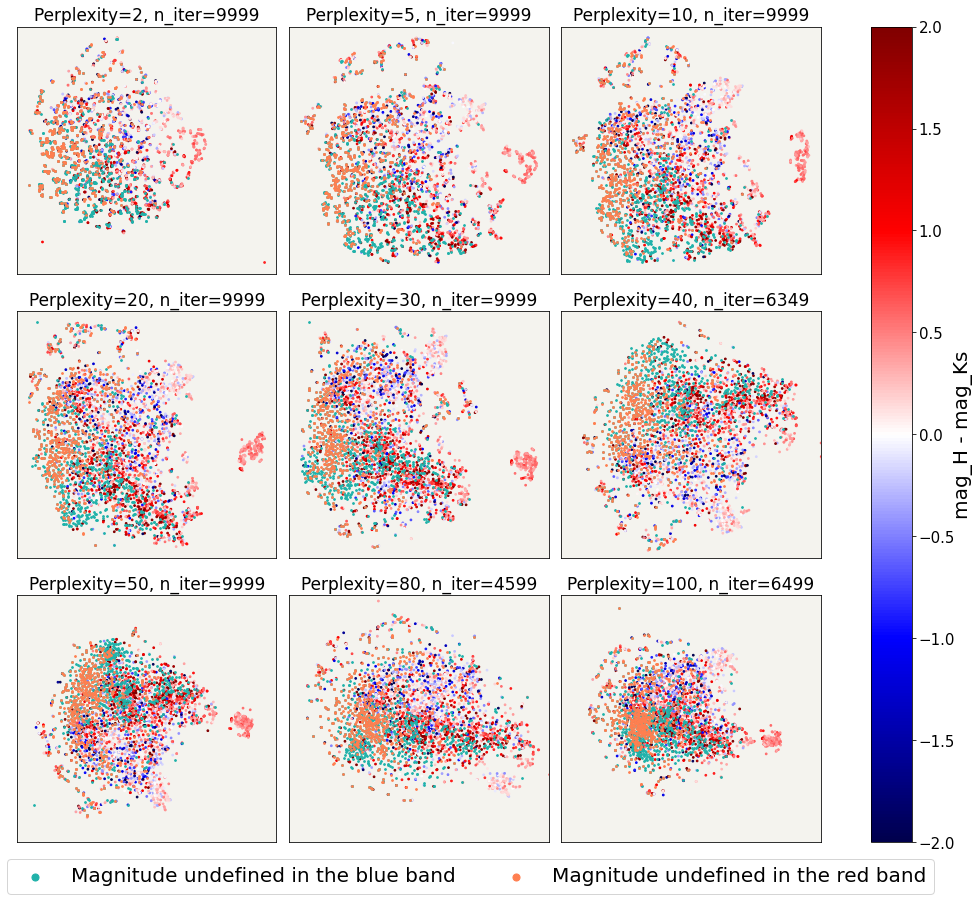

In [135]:
# Plot H-Ks color
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,15), gridspec_kw={'wspace':0.05, 'hspace':0.15})
ax = ax.flatten()

for i in range(len(perplexities)):
    
    # Plot defined colors
    im = ax[i].scatter(X_tsne_arr[i][:,0], X_tsne_arr[i][:,1], s=3, c=H_Ks, cmap='seismic',vmin=-2,vmax=2)
    
     # Plot points where the bluer band encountered an undefined value in mag
    ax[i].scatter(X_tsne_arr[i][:,0][mask_H], X_tsne_arr[i][:,1][mask_H], c='lightseagreen', s=3, 
                  label='Magnitude undefined in the blue band')
    
    # Plot points where the bluer band encountered an undefined value in mag
    ax[i].scatter(X_tsne_arr[i][:,0][mask_Ks], X_tsne_arr[i][:,1][mask_Ks], c='coral', s=3, 
                  label='Magnitude undefined in the red band') 
    
    # Make plot pretty
    ax[i].set_title(f'Perplexity={perplexities[i]}, n_iter={n_iter_arr[i]}', fontsize=17)
    ax[i].set_facecolor('#f4f3ee')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# Adjust the limits for a few plots to not waste space on single outlier
ax[5].set(xlim=(-60,60), ylim=(-50,50))
ax[6].set(xlim=(-60,80), ylim=(-50,50))
ax[7].set(xlim=(-30,30), ylim=(-30,30))
ax[8].set(xlim=(-30,40), ylim=(-30,30))

# Make a single label
lgnd = ax[7].legend(prop={'size': 20},loc='lower center', bbox_to_anchor=(0.7, -0.25), fancybox=True, ncol=2)
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]

# Colorbar and text
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=1)
cbar.set_label('mag_H - mag_Ks', labelpad=-1, size=20)
cbar.ax.tick_params(labelsize=15)

# Save figure
plt.savefig('Saved_Figures/peplex_H_Ks.pdf', facecolor='w')

plt.show()

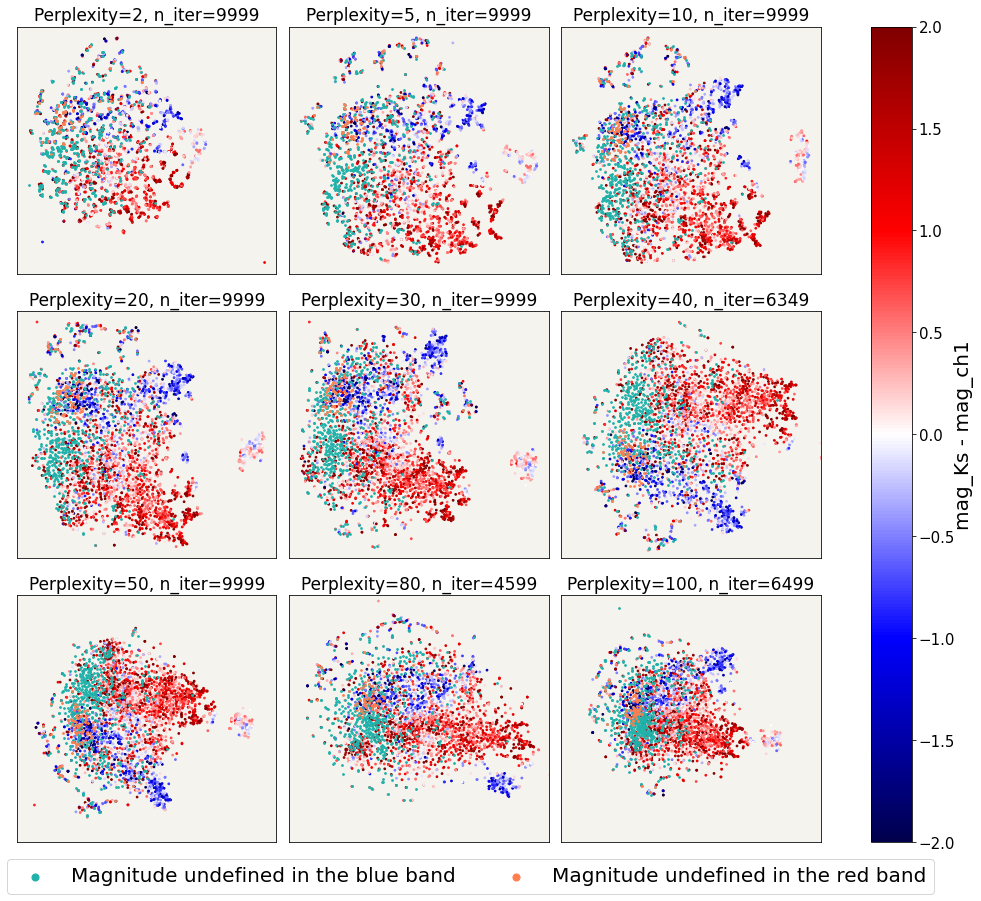

In [141]:
# Plot Ks-ch1 color
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,15), gridspec_kw={'wspace':0.05, 'hspace':0.15})
ax = ax.flatten()

for i in range(len(perplexities)):
    
    # Plot all defined colors
    im = ax[i].scatter(X_tsne_arr[i][:,0], X_tsne_arr[i][:,1], s=3, c=Ks_ch1, cmap='seismic',vmin=-2,vmax=2)
    
    # Plot points where the bluer band encountered an undefined value in mag
    ax[i].scatter(X_tsne_arr[i][:,0][mask_Ks], X_tsne_arr[i][:,1][mask_Ks], c='lightseagreen', s=3,
                  label='Magnitude undefined in the blue band')
    
    # Plot points where the bluer band encountered an undefined value in mag
    ax[i].scatter(X_tsne_arr[i][:,0][mask_ch1], X_tsne_arr[i][:,1][mask_ch1], c='coral', s=3,
                  label='Magnitude undefined in the red band')
    
    # Make plot pretty
    ax[i].set_title(f'Perplexity={perplexities[i]}, n_iter={n_iter_arr[i]}', fontsize=17)
    ax[i].set_facecolor('#f4f3ee')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# Adjust the limits for a few plots to not waste space on single outlier
ax[5].set(xlim=(-60,60), ylim=(-50,50))
ax[6].set(xlim=(-60,80), ylim=(-50,50))
ax[7].set(xlim=(-30,30), ylim=(-30,30))
ax[8].set(xlim=(-30,40), ylim=(-30,30))

# Make a single label
lgnd = ax[7].legend(prop={'size': 20},loc='lower center', bbox_to_anchor=(0.7, -0.25), fancybox=True, ncol=2)
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]

# Colorbar and text
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=1)
cbar.set_label('mag_Ks - mag_ch1', labelpad=-1, size=20)
cbar.ax.tick_params(labelsize=15)

# Save figure
plt.savefig('Saved_Figures/peplex_Ks_ch1.pdf', facecolor='w')

plt.show()

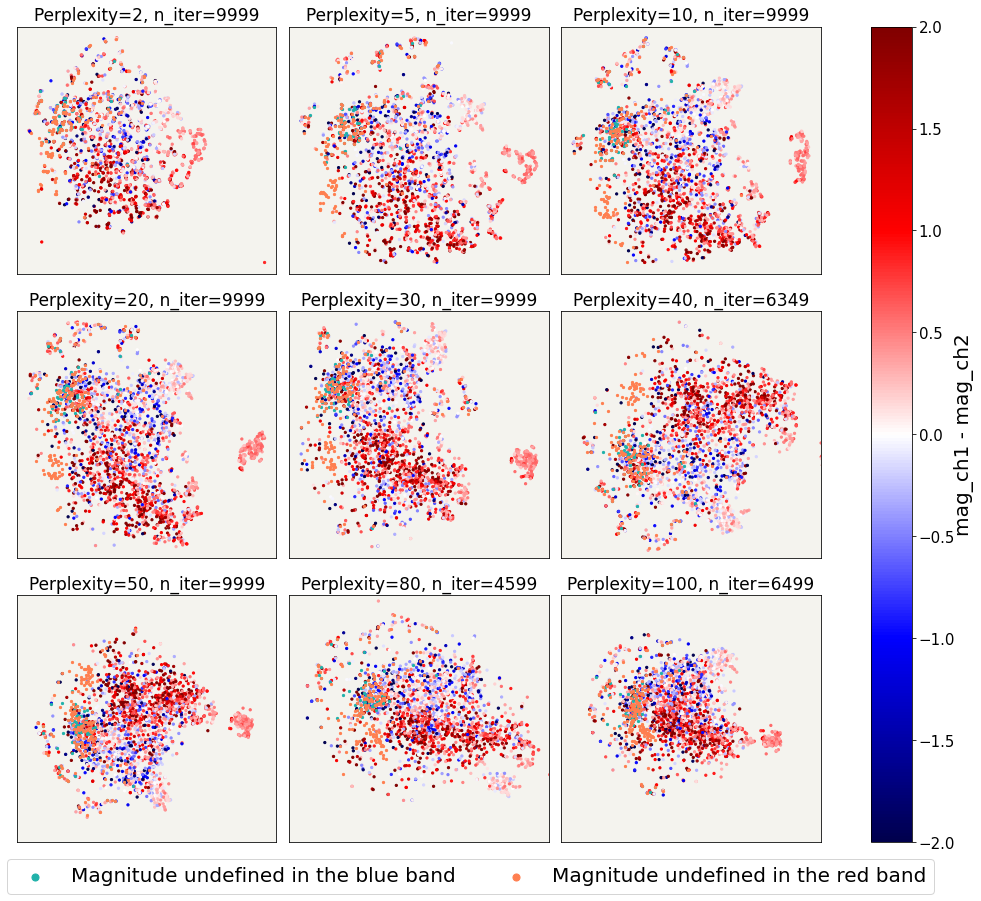

In [143]:
# Plot H-Ks color
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,15), gridspec_kw={'wspace':0.05, 'hspace':0.15})
ax = ax.flatten()

for i in range(len(perplexities)):
    
    # Plot all points
    im = ax[i].scatter(X_tsne_arr[i][:,0], X_tsne_arr[i][:,1], s=5, c=H_Ks, cmap='seismic',vmin=-2,vmax=2)
    
    # Plot points where the bluer band encountered an undefined value in mag
    ax[i].scatter(X_tsne_arr[i][:,0][mask_ch1], X_tsne_arr[i][:,1][mask_ch1], c='lightseagreen', s=5,
                  label='Magnitude undefined in the blue band')
    
    # Plot points where the bluer band encountered an undefined value in mag
    ax[i].scatter(X_tsne_arr[i][:,0][mask_ch2], X_tsne_arr[i][:,1][mask_ch2], c='coral', s=5,
                  label='Magnitude undefined in the red band')
    
    # Make plot pretty
    ax[i].set_title(f'Perplexity={perplexities[i]}, n_iter={n_iter_arr[i]}', fontsize=17)
    ax[i].set_facecolor('#f4f3ee')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
# Adjust the limits for a few plots to not waste space on single outlier
ax[5].set(xlim=(-60,60), ylim=(-50,50))
ax[6].set(xlim=(-60,80), ylim=(-50,50))
ax[7].set(xlim=(-30,30), ylim=(-30,30))
ax[8].set(xlim=(-30,40), ylim=(-30,30))

# Make a single label
lgnd = ax[7].legend(prop={'size': 20},loc='lower center', bbox_to_anchor=(0.7, -0.25), fancybox=True, ncol=2)
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]

# Colorbar and text
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=1)
cbar.set_label('mag_ch1 - mag_ch2', labelpad=-1, size=20)
cbar.ax.tick_params(labelsize=15)

# Save figure
plt.savefig('Saved_Figures/peplex_ch1_ch2.pdf', facecolor='w')

plt.show()

# Labeling color with all udefined colors marked the same

In [24]:
# Define colors myself
uvista = 30 #also cfht
hsc = 31.4
irac = 21.58

# Not sure what is what
H_Ks = -2.5*np.log10(resi_tab['FLUX_APER_H'][:,0] / resi_tab['FLUX_APER_Ks'][:,0]) + uvista - uvista 
Ks_ch1 = -2.5*np.log10(resi_tab['FLUX_APER_Ks'][:,0] / resi_tab['FLUX_APER_ch1'][:,0]) + uvista - irac
ch1_ch2 = -2.5*np.log10(resi_tab['FLUX_APER_ch1'][:,0] / resi_tab['FLUX_APER_ch2'][:,0]) + irac - irac

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


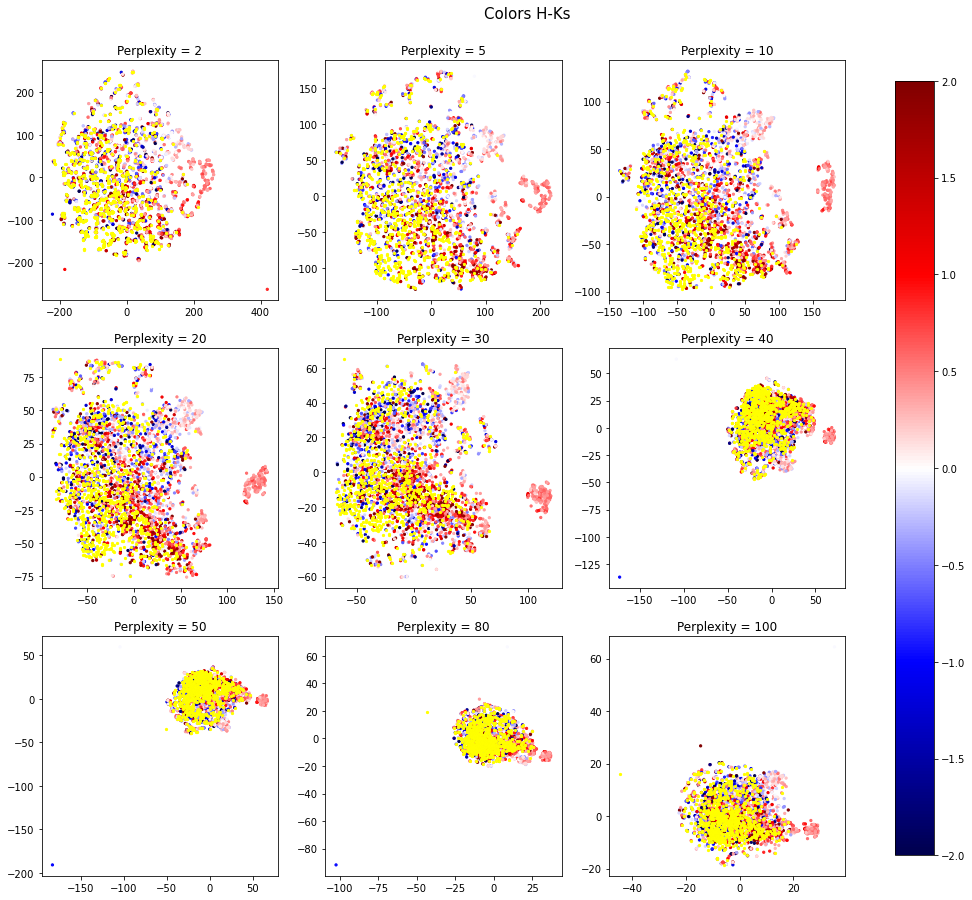

In [25]:
# Plot H-Ks color
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,15))
ax = ax.flatten()

for i in range(len(perplexities)):
    
    im = ax[i].scatter(X_tsne_arr[i][:,0], X_tsne_arr[i][:,1], s=5, c=H_Ks, cmap='seismic', vmin=-2,vmax=2)
    mask1 = np.isnan(H_Ks)
    ax[i].scatter(X_tsne_arr[i][:,0][mask1], X_tsne_arr[i][:,1][mask1], c='yellow', s=5)
    ax[i].set_title(f'Perplexity = {perplexities[i]}')

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
fig.suptitle('Colors H-Ks', fontsize=15, y=0.93)
plt.show()

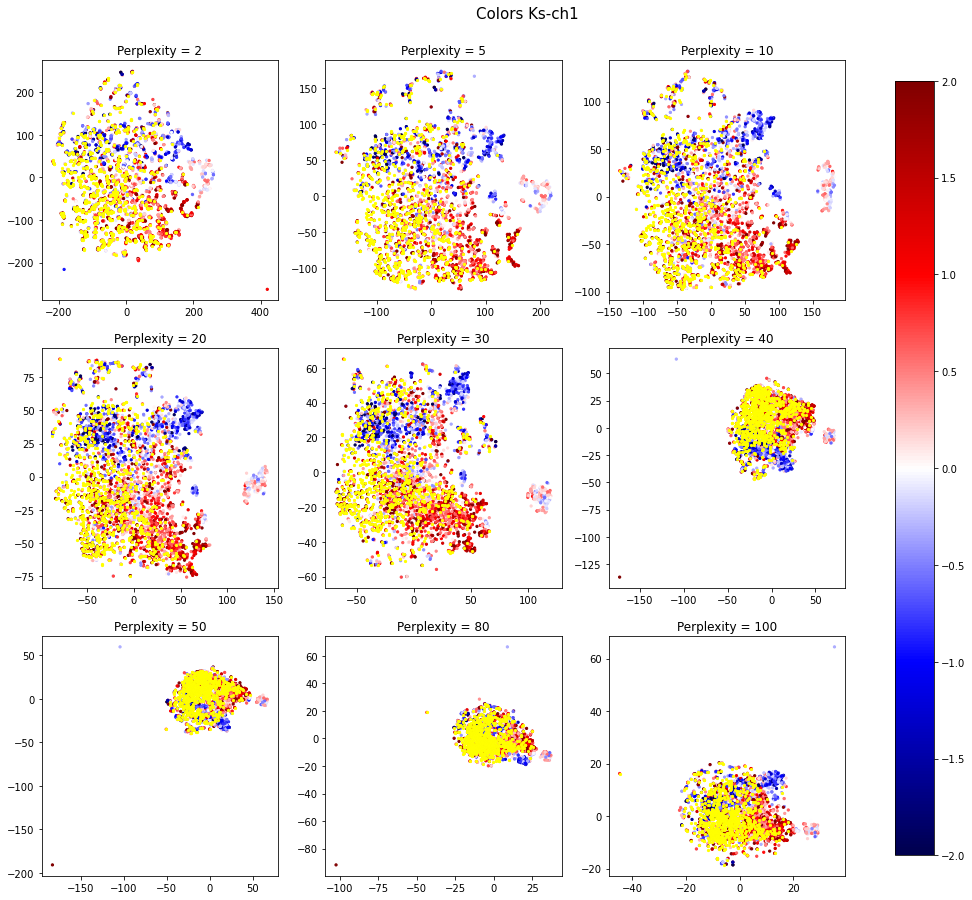

In [26]:
# Plot Ks-ch1 color
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,15))
ax = ax.flatten()

for i in range(len(perplexities)):
    
    im = ax[i].scatter(X_tsne_arr[i][:,0], X_tsne_arr[i][:,1], s=5, c=Ks_ch1, cmap='seismic', vmin=-2,vmax=2)
    mask1 = np.isnan(H_Ks)
    ax[i].scatter(X_tsne_arr[i][:,0][mask1], X_tsne_arr[i][:,1][mask1], c='yellow', s=5)
    ax[i].set_title(f'Perplexity = {perplexities[i]}')

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
fig.suptitle('Colors Ks-ch1', fontsize=15, y=0.93)
plt.show()

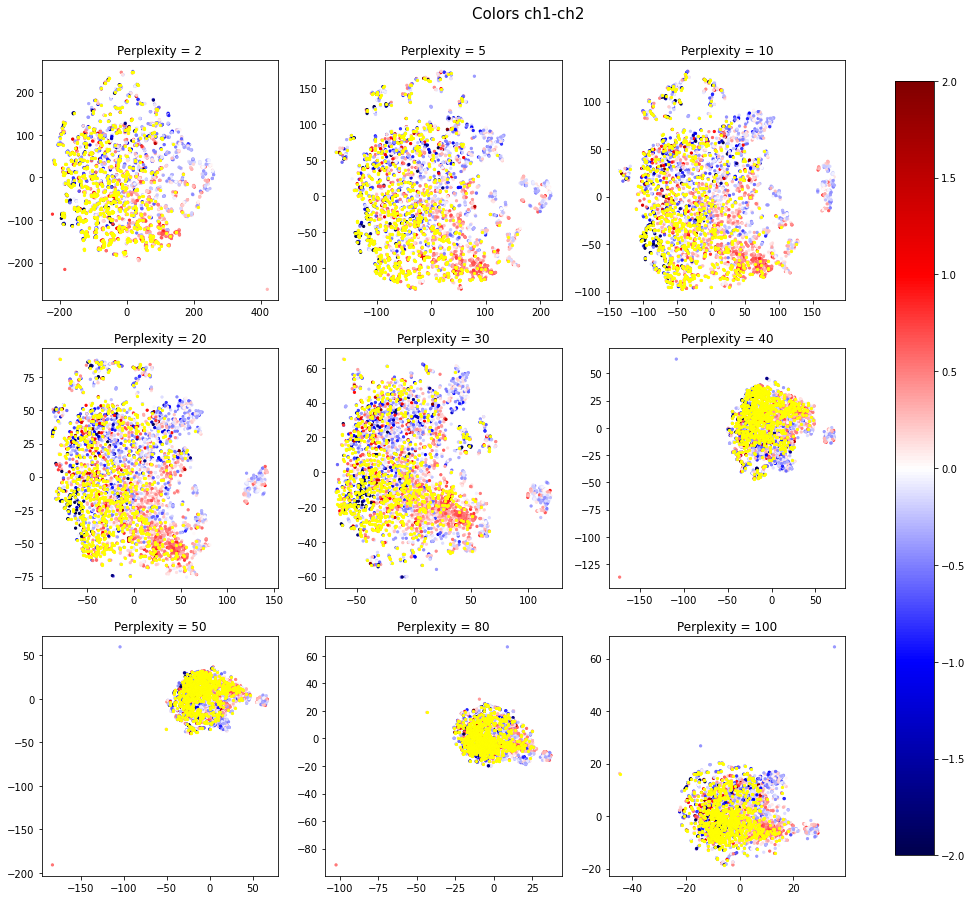

In [27]:
# Plot Ks-ch1 color
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,15))
ax = ax.flatten()

for i in range(len(perplexities)):
    
    im = ax[i].scatter(X_tsne_arr[i][:,0], X_tsne_arr[i][:,1], s=5, c=ch1_ch2, cmap='seismic', vmin=-2,vmax=2)
    mask1 = np.isnan(H_Ks)
    ax[i].scatter(X_tsne_arr[i][:,0][mask1], X_tsne_arr[i][:,1][mask1], c='yellow', s=5)
    ax[i].set_title(f'Perplexity = {perplexities[i]}')

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
fig.suptitle('Colors ch1-ch2', fontsize=15, y=0.93)
plt.show()

## Where does the negative flux come from?

## Labeling matched objects

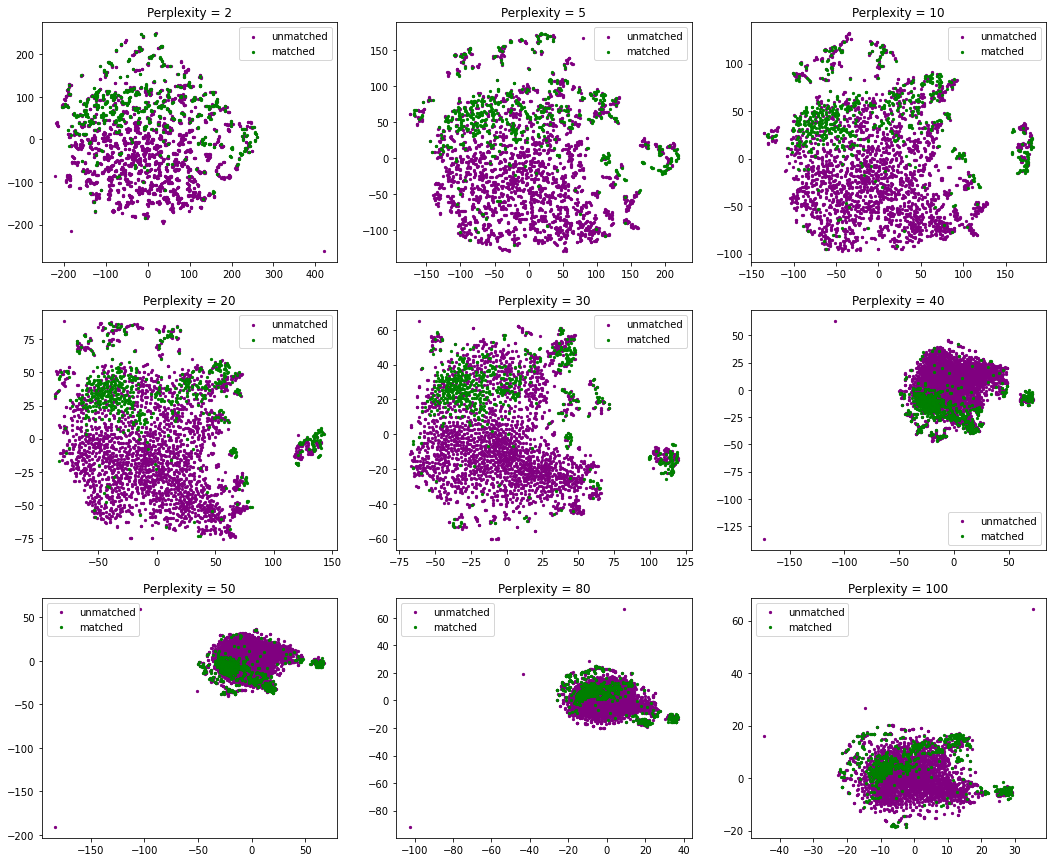

In [28]:
# Plot matched and unmatched objects
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,15))
ax = ax.flatten()

for i in range(len(perplexities)):

    ax[i].scatter(X_tsne_arr[i][:,0][~resi_idx], X_tsne_arr[i][:,1][~resi_idx], c='purple', s=5, label='unmatched')
    ax[i].scatter(X_tsne_arr[i][:,0][resi_idx], X_tsne_arr[i][:,1][resi_idx], c='green', s=5, label='matched')
    ax[i].set_title(f'Perplexity = {perplexities[i]}')
    ax[i].legend()

plt.show()

## Labeling the robust candidades

In [29]:
# Select all objects in resi_tab that are labelled "O" in the NOTES column in labels_tab
O_mask = (labels_tab['NOTES']=='O ')

# Extract the numbers from the list
O_numbers = labels_tab[O_mask]['NUMBER']
print(f'There are {len(O_numbers)} galaxies denoted O: the most interesting ones for our purpose')

# Make a mask for the resi_tab that is 1 (True) for 'O' and 0 (False) for the rest
O_resi_mask = np.zeros(len(resi_tab), dtype=bool)

for i in range(len(resi_tab)):
    
    if resi_tab['NUMBER'][i] in O_numbers:
        O_resi_mask[i] = int(1)
    
    else:
        O_resi_mask[i] = int(0)

# Check it worked
np.sum(O_resi_mask)

There are 62 galaxies denoted O: the most interesting ones for our purpose


62

In [30]:
# Do the same for K
K_mask = (labels_tab['NOTES']=='K ')

# Extract the numbers from the list
K_numbers = labels_tab[K_mask]['NUMBER']
print(f'There are {len(K_numbers)} galaxies denoted K: the next interesting ones for our purpose')

# Make a mask for the resi_tab that is 1 (True) for 'O' and 0 (False) for the rest
K_resi_mask = np.zeros(len(resi_tab), dtype=bool)

for i in range(len(resi_tab)):
    
    if resi_tab['NUMBER'][i] in K_numbers:
        K_resi_mask[i] = True
    
    else:
        K_resi_mask[i] = False

# Check it worked
np.sum(K_resi_mask)

There are 71 galaxies denoted K: the next interesting ones for our purpose


71

In [31]:
# Make a mask that is neither O nor K
other_resi_mask_inv = O_resi_mask + K_resi_mask #remember this has to be inverted

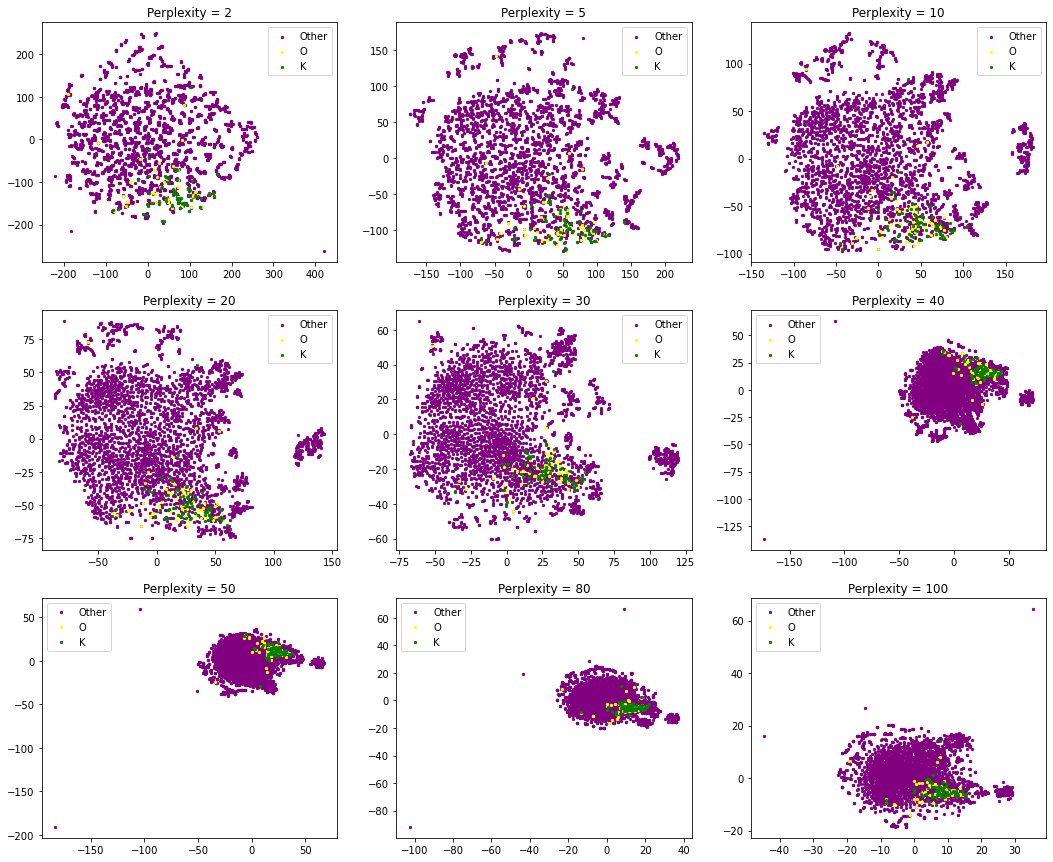

In [32]:
# Plot it for all perplexities

# Plot matched and unmatched objects
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,15))
ax = ax.flatten()

for i in range(len(perplexities)):
    
    ax[i].scatter(X_tsne_arr[i][:,0][~other_resi_mask_inv], X_tsne_arr[i][:,1][~other_resi_mask_inv], 
                  c='purple', s=5, label='Other')
    ax[i].scatter(X_tsne_arr[i][:,0][O_resi_mask], X_tsne_arr[i][:,1][O_resi_mask], 
                  c='yellow', s=5, label='O')
    ax[i].scatter(X_tsne_arr[i][:,0][K_resi_mask], X_tsne_arr[i][:,1][K_resi_mask], 
                  c='green', s=5, label='K')
    ax[i].legend()
    ax[i].set_title(f'Perplexity = {perplexities[i]}')

plt.show()